In [1]:
from classes.basic_optical_gating import BasicOpticalGating as BOG, BasicOpticalGatingPlotter as BOGP, Logger
from classes.drawer import Drawer

In [2]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tf

In [3]:
def v_fitting_standard(y_1, y_2, y_3):
    # Fit using a symmetric 'V' function, to find the interpolated minimum for three datapoints y_1, y_2, y_3,
    # which are considered to be at coordinates x=-1, x=0 and x=+1
    if y_1 == y_2:
        x = -0.5
    elif y_2 == y_3:
        x = 0.5
    elif y_1 >= y_3:
        x = 0.5 * (y_1 - y_3) / (y_1 - y_2)
    else:
        x = 0.5 * (y_1 - y_3) / (y_3 - y_2)

    return x

In [11]:
class BOGR(BOG):
    def get_phases(self):
        super().get_phases()

        #self.phases = []
        subframes = []
        fdiffs = []
        for i, sad in enumerate(self.sads):
            minima = np.argmin(sad[2:-2]) + 2
            #if minima == 5:
            if minima == 20:
                frame = self.sequence[i]
                minima_frame_1 = self.reference_sequence[minima - 1]
                minima_frame_2 = self.reference_sequence[minima]
                minima_frame_3 = self.reference_sequence[minima + 1]

                frame_diff_1 = np.abs(minima_frame_1.astype(np.float32) - frame)
                frame_diff_2 = np.abs(minima_frame_2.astype(np.float32) - frame)
                frame_diff_3 = np.abs(minima_frame_3.astype(np.float32) - frame)
                tf.imwrite("fdiff.tif", np.array([frame_diff_1, frame_diff_2, frame_diff_3]))
                fdiffs.append(np.array([frame_diff_1, frame_diff_2, frame_diff_3]))

                subframe = np.zeros((*self.reference_sequence[0].shape, 3))
                region_size = 8
                xs = np.arange(0, frame.shape[0], region_size)
                ys = np.arange(0, frame.shape[1], region_size)

                for x in xs:
                    for y in ys:
                        y_1 = np.sum(frame_diff_1[x:x+region_size, y:y+region_size])
                        y_2 = np.sum(frame_diff_2[x:x+region_size, y:y+region_size])
                        y_3 = np.sum(frame_diff_3[x:x+region_size, y:y+region_size])
                        minima_x = v_fitting_standard(y_1, y_2, y_3)
                        residual = (self.phases[i] - self.frame_minimas[i]) - minima_x
                        if np.abs(residual) < 0.5:
                            if np.abs(residual) < 0.16:
                                if y_2 != 0:
                                    subframe[x:x+region_size, y:y+region_size, 1] = np.abs(residual)
                            elif self.phases[i] - self.frame_minimas[i] > minima_x:
                                if y_2 != 0:
                                    subframe[x:x+region_size, y:y+region_size, 0] = residual
                            else:
                                if y_2 != 0:
                                    subframe[x:x+region_size, y:y+region_size, 2] = np.abs(residual)
                            """if y_2 != 0:
                                subframe[x:x+region_size, y:y+region_size, 2] = 1 / y_2"""
                        """if minima_x > -0.5 and minima_x < 0.5:
                            if minima_x > 0:
                                subframe[x:x+region_size, y:y+region_size, 0] = minima_x
                                #subframe[x:x+region_size, y:y+region_size, 2] = 0.5 - np.abs(minima_x)
                            else:
                                #subframe[x:x+region_size, y:y+region_size, 0] = 0.5 - np.abs(minima_x)
                                subframe[x:x+region_size, y:y+region_size, 1] = np.abs(minima_x)
                        else:
                            subframe[x:x+region_size, y:y+region_size, 1] = 0#np.abs(minima_x)"""
                        #subframe[x:x+region_size, y:y+region_size, 1] = v_fitting_standard(y_1, y_2, y_3)
                
                subfr = np.mean(subframe)
                subframes.append(subframe)

                #self.phases.append(minima + subfr)
        #self.phases = np.array(self.phases)
        fdiffs = np.array(fdiffs)
        tf.imwrite("fdiffs.tif", fdiffs)
        self.has_run["get_phases"] = True
        subframes = np.array(subframes)
        tf.imwrite("outliers.tif", subframes)
        tf.imwrite("mean.tif", np.mean(subframes, axis = 0))
        print(np.mean(subframes))
        print(np.sum(np.mean(subframes[:, :, :, 0], axis = 0)))
        print(np.sum(np.mean(subframes[:, :, :, 1], axis = 0)))
        print(np.sum(np.mean(subframes[:, :, :, 2], axis = 0)))
        

In [12]:
sequence = "./data/2012-06-20 13.34.11 vid 2x2 multi phase single plane/brightfield/*tif"
reference_sequence = "./data/2012-06-20 13.34.11 vid 2x2 multi phase single plane/ref_seq.tif"
reference_sequence_period = "./data/2012-06-20 13.34.11 vid 2x2 multi phase single plane/ref_seq.txt"

"""sequence = r"E:\data\my data\March 2023 Fluorescence\2023-03-30 16.57.42 Fluor Good sync 7/sequence_8bit.tif"
reference_sequence = r"E:\data\my data\March 2023 Fluorescence\2023-03-30 16.57.42 Fluor Good sync 7/ref_seq.tif"
reference_sequence_period = 7.877846306963839140e+01"""

og = BOGR()
og.logger.set_quiet()
og.set_sequence(sequence)
og.set_reference_sequence(reference_sequence)
og.set_reference_period(reference_sequence_period)
og.run(bias_correct = False, drift_correct = False)

0.04124148699987115
2968.3801316138
1066.8059404488288
3078.970435415151


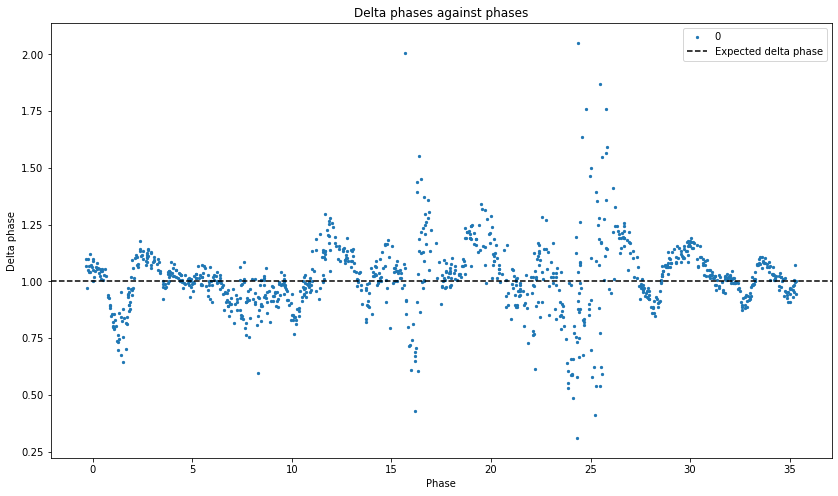

In [6]:
bogp = BOGP(og)
bogp.plot_delta_phases_phases()